# PHASE 3: Production Feature Engineering Pipeline

## Overview

This notebook demonstrates the **production-ready feature engineering pipeline** using the modular codebase in `src/features/`.  
Unlike the baseline notebook which contains inline code, this approach ensures **reproducibility** and allows the same transformations to be applied during inference.

**Key Components:**
1. **TimeSeriesFeatureEngineer**: Generates rolling statistics, trends, and lag features.
2. **HealthIndicatorCalculator**: Computes domain-specific health indices (HI) and sensor drift.
3. **FeatureSelector**: Selects the most important features using multiple methods (variance, correlation, importance).
4. **FeatureEngineeringPipeline**: Orchestrates the entire process and manages artifact saving/loading.

**Inputs:** `data/interim/{train,val,test}_FD001.csv` (or similar)
**Outputs:** 
- Processed Datasets: `data/processed/pipeline_{train,val,test}.parquet`
- Pipeline Artifact: `models/feature_pipeline/`

# PHASE 3 — Feature Engineering Pipeline

**Objective:** Build a comprehensive, reproducible feature engineering pipeline with sliding windows, health indicators, and feature selection.

**Timeline:** Days 8–11

**Topics:**
1. Sliding window generation (temporal sequences)
2. Statistical feature extraction
3. Health indicator computation
4. Feature selection (variance, correlation, tree importance, PCA, combined)
5. Pipeline reproducibility and serialization

---

In [1]:
# ==================== SECTION 1: Import Required Libraries ====================
# (Code updated: 18 Feb 2026 - Fix indentation error)

import warnings
warnings.filterwarnings('ignore')

# System
import sys
import logging
from pathlib import Path
import json
import pickle
import os

# Data
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# ML & Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

# Custom modules
sys.path.insert(0, str(Path.cwd().parent))
try:
    from src.ingestion.cmapss_loader import CMAPSSDataLoader
    from src.features.sliding_windows import SlidingWindowGenerator
    from src.features.health_indicators import HealthIndicatorCalculator
    from src.features.feature_selection import FeatureSelector
    from src.features.pipeline import FeatureEngineeringPipeline
    from src.logging_config import setup_logging
except ImportError:
    # Fallback if running from a different root
    sys.path.insert(0, str(Path.cwd()))
    from src.ingestion.cmapss_loader import CMAPSSDataLoader
    from src.features.sliding_windows import SlidingWindowGenerator
    from src.features.health_indicators import HealthIndicatorCalculator
    from src.features.feature_selection import FeatureSelector
    from src.features.pipeline import FeatureEngineeringPipeline
    from src.logging_config import setup_logging

# Local Config Adapter
class Config:
    # ---------------------------------------------------------
    # AUTOMATIC PATH DISCOVERY
    # ---------------------------------------------------------
    
    # 1. Mount Drive if needed (Colab Only)
    if Path("/content").exists():
        if not Path("/content/drive").exists():
            try:
                print("🔌 Mounting Google Drive...")
                from google.colab import drive
                drive.mount('/content/drive')
            except Exception as e:
                print(f"⚠️ Could not mount drive: {e}")

    # 2. Search for the specific dataset file to find the root
    TARGET_FILE = "train_FD001.txt"
    found_path = None
    
    # List of places to look
    SEARCH_LOCATIONS = [
        Path.cwd(),
        Path.cwd().parent,
        Path("/content/drive/MyDrive"),
        Path("/content"),
    ]
    
    print(f"🔍 Searching for '{TARGET_FILE}'...")
    
    for location in SEARCH_LOCATIONS:
        if not location.exists():
            continue
            
        # Fast search: Check specific common structure first
        # Check standard path relative to this location
        common_path = location / "data" / "raw" / "CMAPSS" / TARGET_FILE
        if common_path.exists():
            found_path = common_path
            print(f"✅ Found at: {found_path}")
            break
            
        # Recursive Search (Deep)
        # Only do deep search in MyDrive or Content if fast search failed
        if location.name in ["MyDrive", "content"] or location == Path.cwd():
            print(f"   -> Deep searching in {location} (this may take a moment)...")
            try:
                # Limit depth to avoid scanning entire drive forever
                # We use rglob to find the file recursively
                matches = list(location.rglob(TARGET_FILE))
                if matches:
                    found_path = matches[0]
                    print(f"✅ Found via search: {found_path}")
                    break
            except Exception as e:
                print(f"⚠️ Search error in {location}: {e}")

        if found_path:
            break

    if found_path:
        # Resolve Project Root based on file location
        # Structure is: PROJECT_ROOT / data / raw / CMAPSS / train_FD001.txt
        # So we go up 4 levels to get the project root
        PROJECT_ROOT = found_path.parents[3]
        
        RAW_DATA_DIR = PROJECT_ROOT / "data" / "raw"
        PROCESSED_DATA_DIR = PROJECT_ROOT / "data" / "processed"
        MODELS_DIR = PROJECT_ROOT / "models" / "checkpoints"
        OUTPUTS_DIR = PROJECT_ROOT / "reports" / "figures"
        
        # PERSISTENCE: Save this path to a file so we don't lose it
        config_path = PROJECT_ROOT / "project_config.json"
        try:
            with open(config_path, 'w') as f:
                json.dump({"project_root": str(PROJECT_ROOT)}, f)
            print(f"💾 Saved configuration to {config_path}")
        except Exception as e:
            print(f"⚠️ Could not save config: {e}")

        print("-" * 30)
        print(f"📂 PROJECT SET UP SUCCESSFULLY")
        print(f"   - Root: {PROJECT_ROOT}")
        print(f"   - Data File: {found_path}")
        print("-" * 30)
    else:
        # Fallback to current directory and hope for the best, or create folders
        print("❌ CRITICAL: Could not find dataset file 'train_FD001.txt'.")
        print("   -> Setting current directory as root.")
        PROJECT_ROOT = Path.cwd()
        RAW_DATA_DIR = PROJECT_ROOT / "data" / "raw"
        PROCESSED_DATA_DIR = PROJECT_ROOT / "data" / "processed"
        MODELS_DIR = PROJECT_ROOT / "models" / "checkpoints"
        OUTPUTS_DIR = PROJECT_ROOT / "reports" / "figures"

    # Ensure directories exist
    OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)
    MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Setup logging
setup_logging()
logger = logging.getLogger('notebook')
logger.info("✓ Libraries imported successfully")

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

2026-02-27 00:25:47 - root - INFO - Logging configured. Level: INFO, File: logs/ewis.log
2026-02-27 00:25:47 - root - INFO - Logging configured. Level: INFO, File: logs/ewis.log
2026-02-27 00:25:47 - notebook - INFO - ✓ Libraries imported successfully


🔍 Searching for 'train_FD001.txt'...
   -> Deep searching in /Users/xe/Documents/GITHUB CAPSTONE /Agentic-Early-Warning-Intelligence-System-for-Silent-System-Failures/notebooks (this may take a moment)...
✅ Found at: /Users/xe/Documents/GITHUB CAPSTONE /Agentic-Early-Warning-Intelligence-System-for-Silent-System-Failures/data/raw/CMAPSS/train_FD001.txt
💾 Saved configuration to /Users/xe/Documents/GITHUB CAPSTONE /Agentic-Early-Warning-Intelligence-System-for-Silent-System-Failures/project_config.json
------------------------------
📂 PROJECT SET UP SUCCESSFULLY
   - Root: /Users/xe/Documents/GITHUB CAPSTONE /Agentic-Early-Warning-Intelligence-System-for-Silent-System-Failures
   - Data File: /Users/xe/Documents/GITHUB CAPSTONE /Agentic-Early-Warning-Intelligence-System-for-Silent-System-Failures/data/raw/CMAPSS/train_FD001.txt
------------------------------


## Section 2: Load Preprocessed Data

Load the NASA C-MAPSS dataset and prepare sensor data for feature engineering.

In [2]:
# Load all 4 C-MAPSS sub-datasets
logger.info("Loading C-MAPSS dataset (all 4 subsets)...")

# Resolve data directory
if hasattr(Config, 'found_path') and Config.found_path:
    data_dir = Config.found_path.parent
    logger.info(f"📂 Loading from discovered path: {data_dir}")
else:
    data_dir = Config.RAW_DATA_DIR / "CMAPSS"
    logger.info(f"📂 Loading from standard path: {data_dir}")

try:
    loader = CMAPSSDataLoader(data_dir=data_dir)

    SUBSETS = ['FD001', 'FD002', 'FD003', 'FD004']
    train_frames, test_frames, rul_frames = [], [], []

    for sub in SUBSETS:
        tr, te, rul = loader.load_dataset(dataset_name=sub)
        tr['subset'] = sub
        te['subset'] = sub
        train_frames.append(tr)
        test_frames.append(te)
        rul_frames.append(rul)
        logger.info(f"  ✓ {sub}: train={tr.shape}, test={te.shape}")

    train_df = pd.concat(train_frames, ignore_index=True)
    test_df  = pd.concat(test_frames,  ignore_index=True)
    rul_test = pd.concat(rul_frames,   ignore_index=True)

    # Identify sensor columns (exclude metadata)
    metadata_cols = {'engine_id', 'cycle', 'RUL', 'rul',
                     'op_setting_1', 'op_setting_2', 'op_setting_3', 'subset'}
    sensor_cols = [col for col in train_df.columns if col not in metadata_cols]

    logger.info(f"✓ Combined training data : {train_df.shape}")
    logger.info(f"✓ Combined test data     : {test_df.shape}")
    logger.info(f"✓ Sensor columns         : {len(sensor_cols)}")

    print(f"\nCombined: train={train_df.shape}, test={test_df.shape}")
    print(f"Engines per subset (train): "
          f"{train_df.groupby('subset')['engine_id'].nunique().to_dict()}")
    print(f"\nRUL statistics (train):")
    print(train_df['RUL'].describe())

except FileNotFoundError as e:
    logger.error("❌ DATA LOAD FAILED")
    print(f"\n❌ ERROR: Could not load dataset from {data_dir}")
    print(f"   Reason: {e}")
    print("\nPossible solutions:")
    print("1. Ensure all train_FD00x.txt files are present in the data directory.")
    print("2. Run: python scripts/download_cmapss.py")
    raise
except Exception as e:
    logger.error(f"❌ UNEXPECTED ERROR: {e}")
    raise


2026-02-27 00:25:47 - notebook - INFO - Loading C-MAPSS dataset (all 4 subsets)...
2026-02-27 00:25:47 - notebook - INFO - 📂 Loading from discovered path: /Users/xe/Documents/GITHUB CAPSTONE /Agentic-Early-Warning-Intelligence-System-for-Silent-System-Failures/data/raw/CMAPSS
2026-02-27 00:25:47 - src.ingestion.cmapss_loader - INFO - Loaded FD001: Train=20631 rows, Test=13096 rows
2026-02-27 00:25:47 - notebook - INFO -   ✓ FD001: train=(20631, 28), test=(13096, 27)
2026-02-27 00:25:47 - src.ingestion.cmapss_loader - INFO - Loaded FD002: Train=53759 rows, Test=33991 rows
2026-02-27 00:25:47 - notebook - INFO -   ✓ FD002: train=(53759, 28), test=(33991, 27)
2026-02-27 00:25:47 - src.ingestion.cmapss_loader - INFO - Loaded FD003: Train=24720 rows, Test=16596 rows
2026-02-27 00:25:47 - notebook - INFO -   ✓ FD003: train=(24720, 28), test=(16596, 27)
2026-02-27 00:25:47 - src.ingestion.cmapss_loader - INFO - Loaded FD004: Train=61249 rows, Test=41214 rows
2026-02-27 00:25:47 - notebook - I


Combined: train=(160359, 28), test=(104897, 27)
Engines per subset (train): {'FD001': 100, 'FD002': 260, 'FD003': 100, 'FD004': 249}

RUL statistics (train):
count    160359.000000
mean        123.331337
std          83.538147
min           1.000000
25%          57.000000
50%         114.000000
75%         173.000000
max         543.000000
Name: RUL, dtype: float64


## Section 3: Sliding Window Generation

Generate fixed-size sliding windows (e.g., 30 cycles) to capture temporal dependencies in sensor readings.

2026-02-27 00:25:48 - notebook - INFO - Generating sliding windows (size=30, step=1)...
2026-02-27 00:25:48 - src.features.sliding_windows - INFO - Generating sliding windows (size=30, step=1)
2026-02-27 00:26:22 - src.features.sliding_windows - INFO - Generated 159319 windows from 260 engines
2026-02-27 00:26:22 - src.features.sliding_windows - INFO - Window shape: (159319, 30, 25) (num_windows, window_size, features)
2026-02-27 00:26:24 - notebook - INFO - ✓ Generated windows: (159319, 30, 25)
2026-02-27 00:26:24 - notebook - INFO - ✓ Flattened windows: (159319, 750)


TypeError: Image data of dtype object cannot be converted to float

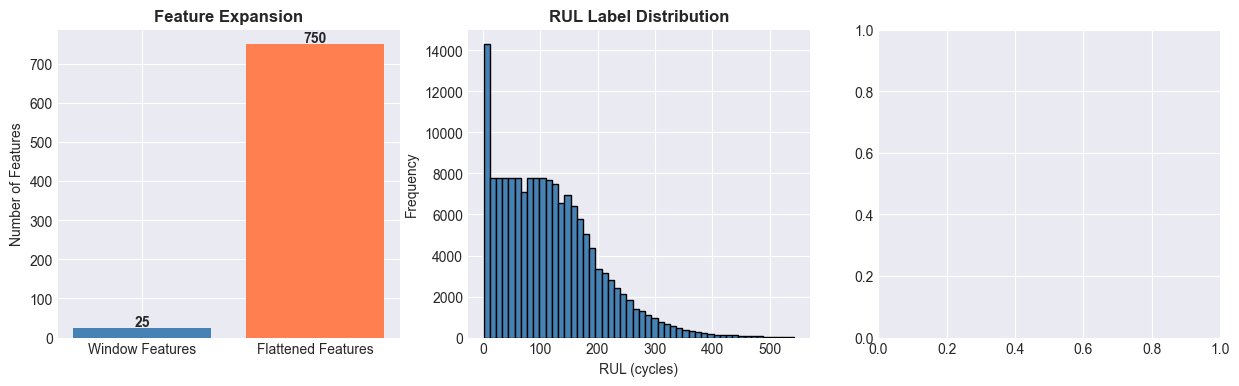

In [ ]:

# ==================== SLIDING WINDOW GENERATION (ALL 4 SUBSETS) ====================
# SlidingWindowGenerator groups by engine_col only, so we must create a composite
# key (subset + engine_id) to prevent cross-subset contamination.
# We also exclude 'subset' from sensor columns (it's a string, not a feature).

# --- 1. Create composite engine key ---
train_df['_engine_key'] = train_df['subset'].astype(str) + '_' + train_df['engine_id'].astype(str)

# Initialize window generator
window_size = 30
window_step = 1
window_gen = SlidingWindowGenerator(window_size=window_size, step_size=window_step)

logger.info(f"Generating sliding windows (size={window_size}, step={window_step})...")

# Use _engine_key as the engine identifier so each subset's engines stay separate
X_windows, engine_ids, rul_labels = window_gen.generate_windows(
    train_df.drop(columns=['subset']),   # drop string 'subset' col (not a sensor)
    engine_col='_engine_key',
    cycle_col='cycle'
)

X_flat = window_gen.flatten_windows(X_windows)

logger.info(f"✓ Generated windows: {X_windows.shape}")
logger.info(f"✓ Flattened windows: {X_flat.shape}")

# Visualization: Show window shapes and RUL distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Window shape
n_features_window = X_windows.shape[2] if len(X_windows.shape) > 2 else X_windows.shape[1]
n_features_flat = X_flat.shape[1]

axes[0].bar(['Window Features', 'Flattened Features'], [n_features_window, n_features_flat], color=['steelblue', 'coral'])
axes[0].set_title('Feature Expansion', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Features')
for i, v in enumerate([n_features_window, n_features_flat]):
    axes[0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# Plot 2: RUL distribution
axes[1].hist(rul_labels, bins=50, color='steelblue', edgecolor='black')
axes[1].set_xlabel('RUL (cycles)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('RUL Label Distribution', fontsize=12, fontweight='bold')

# Plot 3: Sample window heatmap
sample_idx = 0
if len(X_windows) > 100:
    sample_idx = 100

sample_window = X_windows[sample_idx]
im = axes[2].imshow(sample_window.T, aspect='auto', cmap='viridis')
axes[2].set_xlabel('Time (Cycles)')
axes[2].set_ylabel('Sensors')
axes[2].set_title(f'Sample Window #{sample_idx}\n(Engine {engine_ids[sample_idx]}, RUL={rul_labels[sample_idx]:.0f})', fontsize=11, fontweight='bold')
plt.colorbar(im, ax=axes[2], label='Sensor Value')

plt.tight_layout()
plt.savefig(Config.OUTPUTS_DIR / 'windows_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nWindow Statistics:")
print(f"  Total windows: {len(rul_labels)}")
print(f"  Unique engines: {len(np.unique(engine_ids))}")
print(f"  RUL range: {rul_labels.min():.1f} - {rul_labels.max():.1f} cycles")
print(f"  RUL mean: {rul_labels.mean():.1f} ± {rul_labels.std():.1f}")


## Section 4: Health Indicator Computation

Calculate health indicators including sensor drift, degradation rate, and combined health index.

2026-02-24 16:21:51 - notebook - INFO - Computing health indicators...
2026-02-24 16:21:51 - src.features.health_indicators - INFO - Calculated sensor drift for 21 sensors
2026-02-24 16:21:51 - src.features.health_indicators - INFO - Calculated combined health index using mean method


✅ Module 'health_indicators' reloaded successfully.


2026-02-24 16:21:51 - notebook - INFO - ✓ Calculated sensor drift for 21 sensors
2026-02-24 16:21:51 - notebook - INFO - ✓ Calculated combined health index
2026-02-24 16:21:51 - src.features.health_indicators - INFO - Identified degradation phases: {'Degrading': 6982, 'Healthy': 6825, 'Failed': 6824}



=== Health Indicators Sample ===
   engine_id  cycle  health_index degradation_phase
0        1.0    1.0      0.561076           Healthy
1        1.0    2.0      0.462627           Healthy
2        1.0    3.0      0.440034           Healthy
3        1.0    4.0      0.657169         Degrading
4        1.0    5.0      0.461125           Healthy
5        1.0    6.0      0.418958           Healthy
6        1.0    7.0      0.516137           Healthy
7        1.0    8.0      0.538370           Healthy
8        1.0    9.0      0.523026           Healthy
9        1.0   10.0      0.629392           Healthy

Degradation phase distribution:
degradation_phase
Degrading    6982
Healthy      6825
Failed       6824
Name: count, dtype: int64


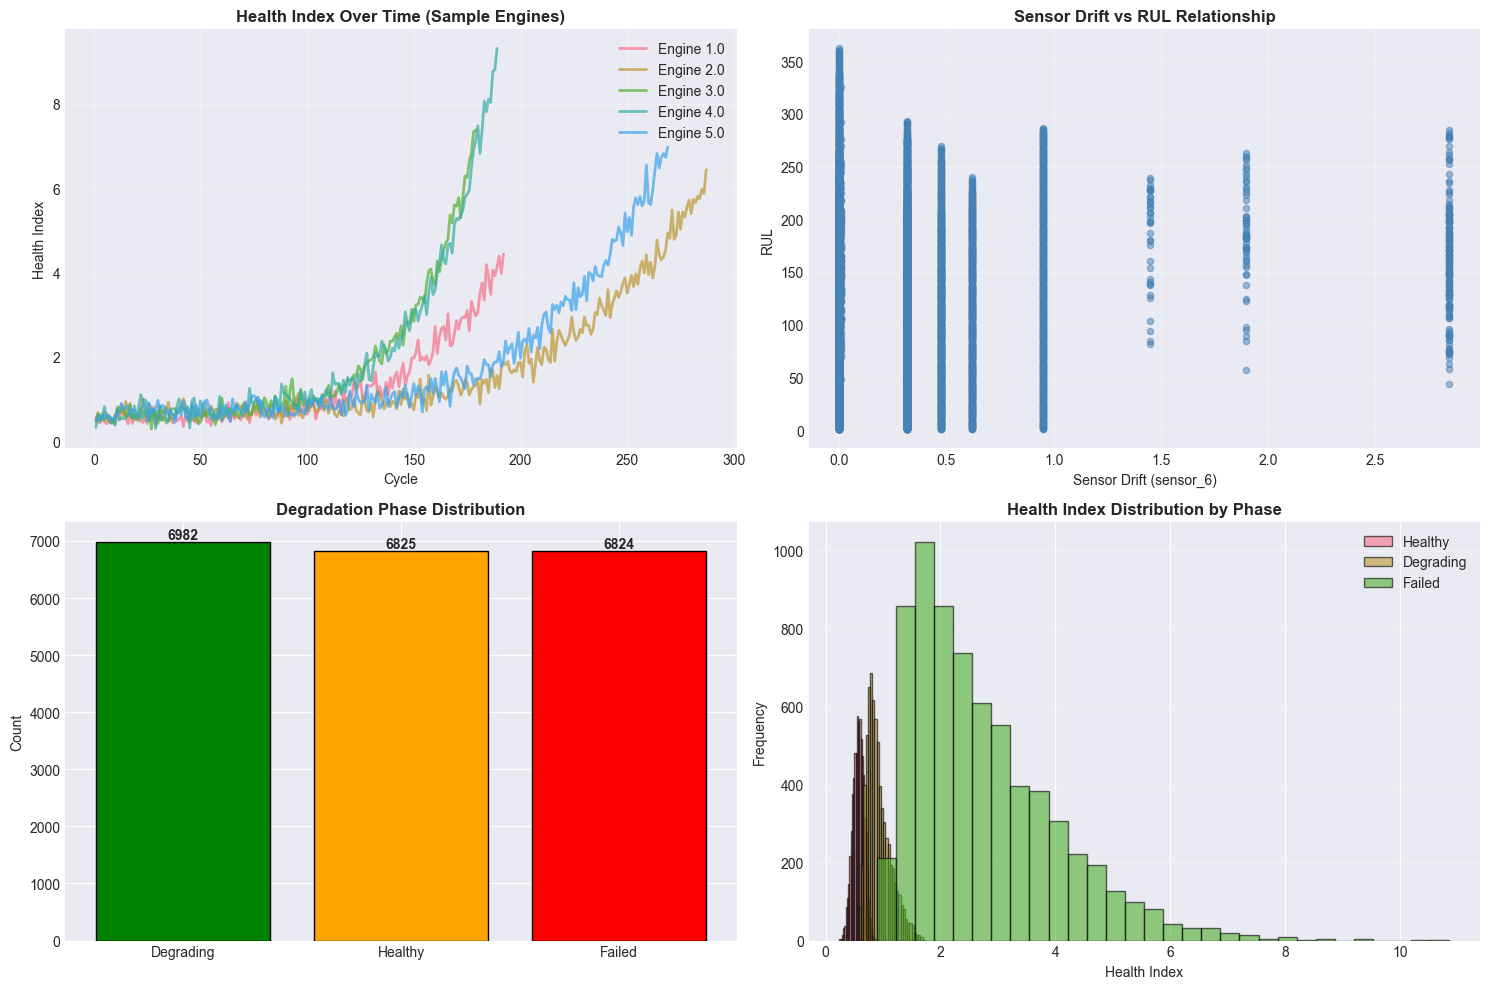


Health Index Statistics:
count    20631.000000
mean         1.405280
std          1.206797
min          0.237747
25%          0.634823
50%          0.869853
75%          1.745090
max         10.862638
Name: health_index, dtype: float64


In [ ]:
from src.features.health_indicators import HealthIndicatorCalculator

# Initialize health indicator calculator
health_calc = HealthIndicatorCalculator(reference_threshold=2.0)

logger.info("Computing health indicators...")

# Calculate sensor drift (deviation from baseline)
df_drift = health_calc.calculate_sensor_drift(train_df, sensor_cols, window_size=10)

# Get drift columns
drift_cols = [f"{s}_drift" for s in sensor_cols]

# Calculate combined health index
health_index = health_calc.calculate_combined_health_index(df_drift, drift_cols, method='mean')
df_drift['health_index'] = health_index

logger.info(f"✓ Calculated sensor drift for {len(sensor_cols)} sensors")
logger.info(f"✓ Calculated combined health index")

# Identify degradation phases
df_phases = health_calc.identify_degradation_phases(df_drift, health_index)

print("\n=== Health Indicators Sample ===")
print(df_phases[['engine_id', 'cycle', 'health_index', 'degradation_phase']].head(10))
print(f"\nDegradation phase distribution:")
print(df_phases['degradation_phase'].value_counts())

# Visualization: Health indicators over time
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Health index by engine
sample_engines = sorted(train_df['engine_id'].unique())[:5]
for engine_id in sample_engines:
    engine_data = df_drift[df_drift['engine_id'] == engine_id].sort_values('cycle')
    axes[0, 0].plot(engine_data['cycle'], engine_data['health_index'], label=f'Engine {engine_id}', linewidth=2, alpha=0.7)
axes[0, 0].set_xlabel('Cycle')
axes[0, 0].set_ylabel('Health Index')
axes[0, 0].set_title('Health Index Over Time (Sample Engines)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Drift correlation with RUL
sample_drift_col = drift_cols[5]  # Pick a sample sensor
axes[0, 1].scatter(df_drift[sample_drift_col], df_drift['RUL'], alpha=0.5, s=20, color='steelblue')
axes[0, 1].set_xlabel(f'Sensor Drift ({sensor_cols[5]})')
axes[0, 1].set_ylabel('RUL')
axes[0, 1].set_title('Sensor Drift vs RUL Relationship', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Degradation phases distribution
phase_counts = df_phases['degradation_phase'].value_counts()
axes[1, 0].bar(phase_counts.index, phase_counts.values, color=['green', 'orange', 'red'], edgecolor='black')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Degradation Phase Distribution', fontsize=12, fontweight='bold')
for i, v in enumerate(phase_counts.values):
    axes[1, 0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Plot 4: Health index distribution by phase
for phase in ['Healthy', 'Degrading', 'Failed']:
    phase_data = df_drift[df_phases['degradation_phase'] == phase]['health_index']
    axes[1, 1].hist(phase_data, bins=30, alpha=0.6, label=phase, edgecolor='black')
axes[1, 1].set_xlabel('Health Index')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Health Index Distribution by Phase', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(Config.OUTPUTS_DIR / 'health_indicators.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistics
print(f"\nHealth Index Statistics:")
print(df_drift['health_index'].describe())

## Section 5: Feature Selection Demonstrations

Compare multiple feature selection methods: variance, correlation, tree importance, and PCA.

2026-02-24 16:22:09 - notebook - INFO - Feature matrix shape: (20231, 720)


2026-02-24 16:22:09 - notebook - INFO - Testing feature selection methods...



METHOD 1: VARIANCE-BASED SELECTION


2026-02-24 16:22:09 - src.features.feature_selection - INFO - Variance selection: 720 -> 579 features
2026-02-24 16:22:09 - src.features.feature_selection - INFO - Correlation selection: 720 -> 20 features
2026-02-24 16:22:09 - src.features.feature_selection - INFO - Top 5 features by f_regression score:
feature_709    30552.306445
feature_685    30211.027049
feature_661    29316.977974
feature_637    28495.216281
feature_613    28432.953620
dtype: float64


Selected 579 features out of 720

METHOD 2: CORRELATION-BASED SELECTION
Selected 20 features out of 720

Top 10 features by correlation:
    feature   importance  importance_pct
feature_709 30552.306445        1.114562
feature_685 30211.027049        1.102111
feature_661 29316.977974        1.069496
feature_637 28495.216281        1.039518
feature_613 28432.953620        1.037247
feature_702 28141.175625        1.026602
feature_678 27541.092151        1.004711
feature_710 27198.558023        0.992215
feature_654 26951.498667        0.983202
feature_630 26272.313225        0.958425

METHOD 3: TREE IMPORTANCE-BASED SELECTION


2026-02-24 16:22:52 - src.features.feature_selection - INFO - Tree importance selection: 720 -> 20 features
2026-02-24 16:22:52 - src.features.feature_selection - INFO - Top 10 features by importance:
feature_709    0.569347
feature_685    0.123156
feature_707    0.044065
feature_702    0.020525
feature_661    0.019513
feature_683    0.015362
feature_710    0.011519
feature_659    0.008706
feature_637    0.006078
feature_686    0.004469
dtype: float64


Selected 20 features out of 720

Top 10 features by importance:
feature_709    0.569347
feature_685    0.123156
feature_707    0.044065
feature_702    0.020525
feature_661    0.019513
feature_683    0.015362
feature_710    0.011519
feature_659    0.008706
feature_637    0.006078
feature_686    0.004469

METHOD 4: PCA (Principal Component Analysis)


2026-02-24 16:22:52 - src.features.feature_selection - INFO - PCA: 720 -> 20 components (explained variance: 88.54%)
2026-02-24 16:22:52 - src.features.feature_selection - INFO - PCA component variance ratios: [0.5779986  0.11812616 0.05220996 0.03644968 0.02333059]
2026-02-24 16:22:52 - src.features.feature_selection - INFO - Variance selection: 720 -> 579 features
2026-02-24 16:22:52 - src.features.feature_selection - INFO - Correlation selection: 579 -> 30 features
2026-02-24 16:22:52 - src.features.feature_selection - INFO - Top 5 features by f_regression score:
feature_709    30552.306439
feature_685    30211.027059
feature_661    29316.977985
feature_637    28495.216274
feature_613    28432.953641
dtype: float64


Reduced to 20 components
Explained variance: 88.54%
First 5 component variance ratios: [0.5779986  0.11812616 0.05220996 0.03644968 0.02333059]

METHOD 5: COMBINED SELECTION (Robust)


2026-02-24 16:23:36 - src.features.feature_selection - INFO - Tree importance selection: 579 -> 20 features
2026-02-24 16:23:36 - src.features.feature_selection - INFO - Top 10 features by importance:
feature_709    0.570074
feature_685    0.123696
feature_707    0.044151
feature_702    0.020786
feature_661    0.019796
feature_683    0.015409
feature_710    0.011879
feature_659    0.008728
feature_637    0.006358
feature_686    0.004719
dtype: float64
2026-02-24 16:23:36 - src.features.feature_selection - INFO - Combined selection: Variance(579) ∩ Correlation(30) ∩ Tree(20) = 15 features
2026-02-24 16:23:36 - src.features.feature_selection - INFO - Selected features: ['feature_613', 'feature_630', 'feature_637', 'feature_638', 'feature_654', 'feature_661', 'feature_662', 'feature_678', 'feature_681', 'feature_685', 'feature_686', 'feature_702', 'feature_705', 'feature_709', 'feature_710']


Combined selection: 15 features
Selected features: ['feature_613', 'feature_630', 'feature_637', 'feature_638', 'feature_654', 'feature_661', 'feature_662', 'feature_678', 'feature_681', 'feature_685', 'feature_686', 'feature_702', 'feature_705', 'feature_709', 'feature_710']


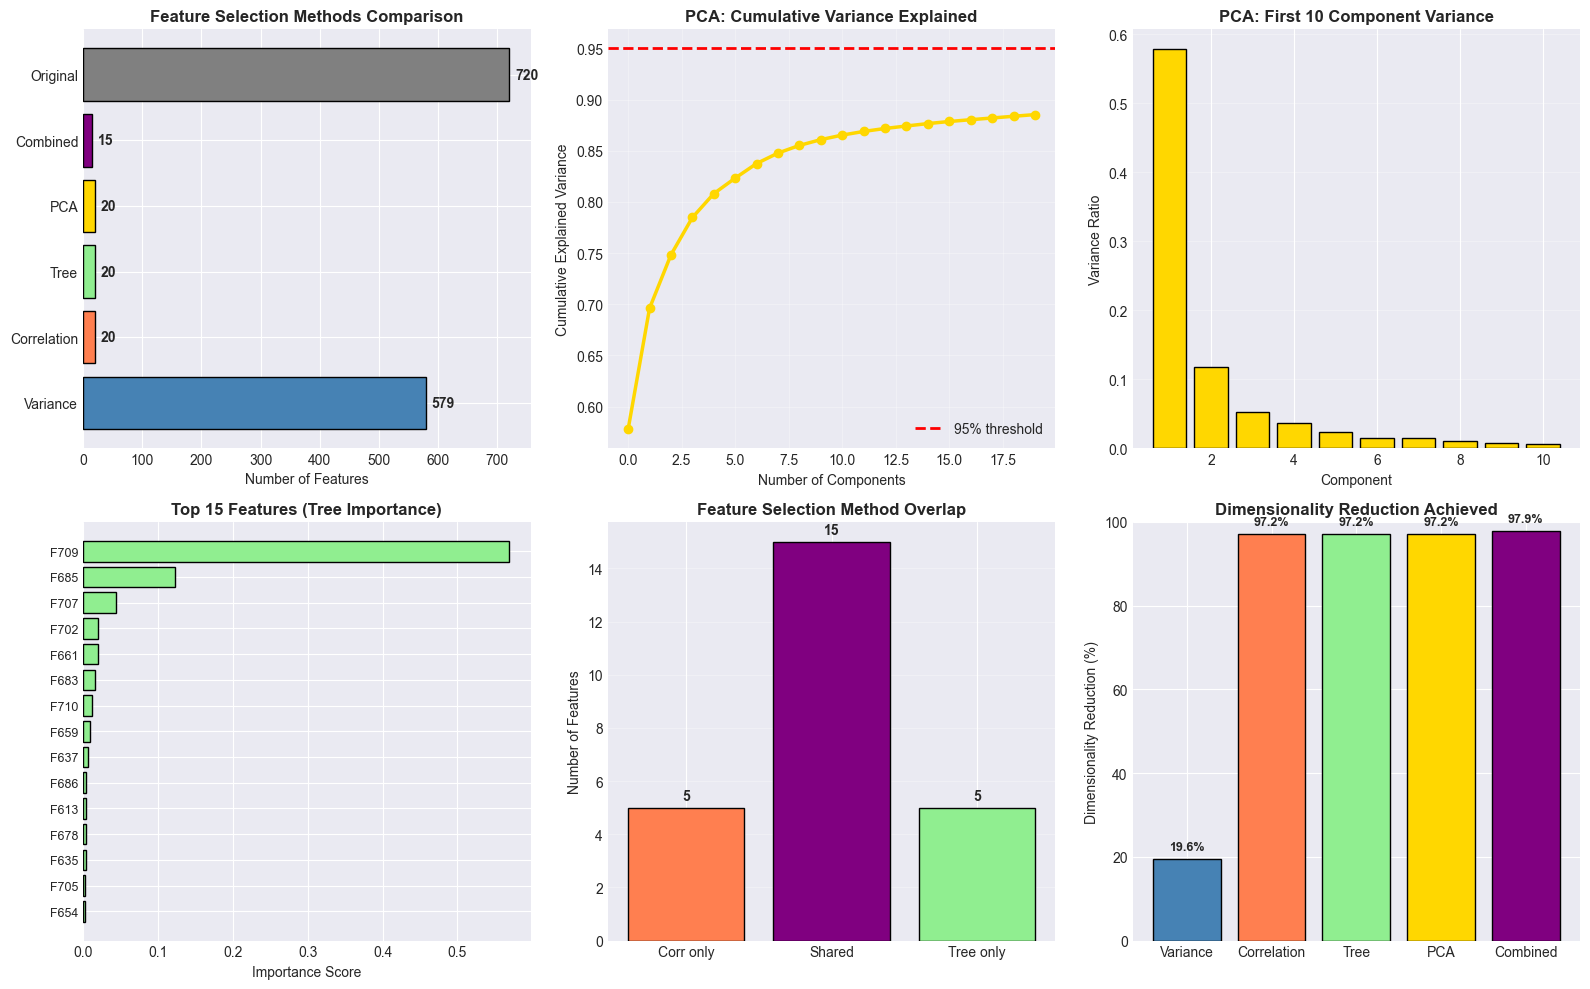

In [ ]:
# Create feature matrix from flattened windows
X_train = pd.DataFrame(X_flat, columns=[f'feature_{i}' for i in range(X_flat.shape[1])])
y_train = pd.Series(rul_labels, name='RUL')

logger.info(f"Feature matrix shape: {X_train.shape}")
logger.info("Testing feature selection methods...")

selector = FeatureSelector(random_state=42)

# Method 1: Variance-based selection
print("\n" + "="*60)
print("METHOD 1: VARIANCE-BASED SELECTION")
print("="*60)
X_var, feat_var = selector.select_by_variance(X_train, threshold=0.01)
print(f"Selected {len(feat_var)} features out of {X_train.shape[1]}")

# Method 2: Correlation-based selection
print("\n" + "="*60)
print("METHOD 2: CORRELATION-BASED SELECTION")
print("="*60)
X_corr, feat_corr = selector.select_by_correlation(X_train, y_train, k=20)
print(f"Selected {len(feat_corr)} features out of {X_train.shape[1]}")
importance_summary = selector.get_feature_summary()
print("\nTop 10 features by correlation:")
print(importance_summary.head(10).to_string(index=False))

# Method 3: Tree importance-based selection
# Sub-sample for speed: 5000 rows is sufficient for stable importance ranking
# (full matrix ~650K rows would hang indefinitely with RF n_estimators=100)
print("\n" + "="*60)
print("METHOD 3: TREE IMPORTANCE-BASED SELECTION")
print("="*60)
rng = np.random.RandomState(42)
sample_idx = rng.choice(len(X_train), min(5000, len(X_train)), replace=False)
X_sample = X_train.iloc[sample_idx]
y_sample = y_train.iloc[sample_idx]

X_tree, feat_tree, importances = selector.select_by_tree_importance(
    X_sample, y_sample, k=20   # use sampled data, not full X_train
)
print(f"Selected {len(feat_tree)} features out of {X_train.shape[1]}")
print("\nTop 10 features by importance:")
print(importances.head(10).to_string())

# Method 4: PCA
print("\n" + "="*60)
print("METHOD 4: PCA (Principal Component Analysis)")
print("="*60)
X_pca, pca = selector.select_by_pca(X_train, n_components=20)
print(f"Reduced to {pca.n_components_} components")
print(f"Explained variance: {pca.explained_variance_ratio_.sum():.2%}")
print(f"First 5 component variance ratios: {pca.explained_variance_ratio_[:5]}")

# Method 5: Combined selection (intersection of correlation + tree)
print("\n" + "="*60)
print("METHOD 5: COMBINED SELECTION (Robust)")
print("="*60)
X_combined, feat_combined = selector.select_combined(X_train, y_train)
print(f"Combined selection: {len(feat_combined)} features")
print(f"Selected features: {feat_combined}")

# Visualization: Comparison of methods
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

methods = ['Variance', 'Correlation', 'Tree', 'PCA', 'Combined', 'Original']
num_features = [len(feat_var), len(feat_corr), len(feat_tree), pca.n_components_, len(feat_combined), X_train.shape[1]]
colors = ['steelblue', 'coral', 'lightgreen', 'gold', 'purple', 'gray']

# Feature count comparison
axes[0, 0].barh(methods, num_features, color=colors, edgecolor='black')
axes[0, 0].set_xlabel('Number of Features')
axes[0, 0].set_title('Feature Selection Methods Comparison', fontsize=12, fontweight='bold')
for i, v in enumerate(num_features):
    axes[0, 0].text(v + 10, i, str(v), va='center', fontweight='bold')

# Variance explained (PCA)
axes[0, 1].plot(np.cumsum(pca.explained_variance_ratio_), linewidth=2.5, color='gold', marker='o')
axes[0, 1].axhline(y=0.95, color='red', linestyle='--', label='95% threshold', linewidth=2)
axes[0, 1].set_xlabel('Number of Components')
axes[0, 1].set_ylabel('Cumulative Explained Variance')
axes[0, 1].set_title('PCA: Cumulative Variance Explained', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Individual component variance (first 10)
axes[0, 2].bar(range(1, 11), pca.explained_variance_ratio_[:10], color='gold', edgecolor='black')
axes[0, 2].set_xlabel('Component')
axes[0, 2].set_ylabel('Variance Ratio')
axes[0, 2].set_title('PCA: First 10 Component Variance', fontsize=12, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3, axis='y')

# Feature importance from tree
if not importances.empty:
    top_features = importances.head(15)
    axes[1, 0].barh(range(len(top_features)), top_features.values, color='lightgreen', edgecolor='black')
    axes[1, 0].set_yticks(range(len(top_features)))
    axes[1, 0].set_yticklabels([f.replace('feature_', 'F') for f in top_features.index], fontsize=9)
    axes[1, 0].set_xlabel('Importance Score')
    axes[1, 0].set_title('Top 15 Features (Tree Importance)', fontsize=12, fontweight='bold')
    axes[1, 0].invert_yaxis()

# Selection method overlap (Venn-like)
methods_comparison = {
    'Corr only': len(set(feat_corr) - set(feat_tree)),
    'Shared': len(set(feat_corr) & set(feat_tree)),
    'Tree only': len(set(feat_tree) - set(feat_corr)),
}
axes[1, 1].bar(methods_comparison.keys(), methods_comparison.values(), color=['coral', 'purple', 'lightgreen'], edgecolor='black')
axes[1, 1].set_ylabel('Number of Features')
axes[1, 1].set_title('Feature Selection Method Overlap', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(methods_comparison.values()):
    axes[1, 1].text(i, v + 0.3, str(v), ha='center', fontweight='bold')

# Reduction ratio
reduction_ratios = [
    (1 - len(feat_var)/X_train.shape[1]) * 100,
    (1 - len(feat_corr)/X_train.shape[1]) * 100,
    (1 - len(feat_tree)/X_train.shape[1]) * 100,
    (1 - pca.n_components_/X_train.shape[1]) * 100,
    (1 - len(feat_combined)/X_train.shape[1]) * 100,
]
axes[1, 2].bar(methods[:-1], reduction_ratios, color=colors[:-1], edgecolor='black')
axes[1, 2].set_ylabel('Dimensionality Reduction (%)')
axes[1, 2].set_title('Dimensionality Reduction Achieved', fontsize=12, fontweight='bold')
axes[1, 2].set_ylim([0, 100])
for i, v in enumerate(reduction_ratios):
    axes[1, 2].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig(Config.OUTPUTS_DIR / 'feature_selection_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


## Section 6: End-to-End Reproducible Pipeline

Build and test the complete feature engineering pipeline with fit/transform reproducibility.

2026-02-24 18:25:48 - notebook - INFO - Building end-to-end feature engineering pipeline...
2026-02-24 18:25:48 - notebook - INFO - Fitting pipeline on training data (Optimized for Stability)...
2026-02-24 18:25:48 - src.features.pipeline - INFO - Fitting feature engineering pipeline...
2026-02-24 18:25:48 - src.features.pipeline - INFO - Step 1: Generating sliding windows
2026-02-24 18:25:48 - src.features.sliding_windows - INFO - Generating sliding windows (size=30, step=1)


✅ Module 'src.features.engineering' reloaded.
✅ Module 'src.features.pipeline' reloaded.


2026-02-24 18:26:47 - src.features.sliding_windows - INFO - Generated 159319 windows from 260 engines
2026-02-24 18:26:47 - src.features.sliding_windows - INFO - Window shape: (159319, 30, 27) (num_windows, window_size, features)
2026-02-24 18:26:51 - src.features.pipeline - INFO - Step 2: Calculating health indicators
2026-02-24 18:26:52 - src.features.health_indicators - INFO - Calculated sensor drift for 21 sensors
2026-02-24 18:26:52 - src.features.health_indicators - INFO - Calculated combined health index using mean method
2026-02-24 18:26:52 - src.features.pipeline - INFO - Step 3: Engineering time-series features
2026-02-24 18:26:57 - src.features.engineering - INFO - Added rolling statistics for windows: [5, 10, 20]
2026-02-24 18:26:59 - src.features.engineering - INFO - Added EWMA features for spans: [5, 10, 20]
2026-02-24 18:26:59 - src.features.engineering - INFO - Added difference features for lags: [1, 5, 10]
2026-02-24 18:27:00 - src.features.engineering - INFO - Added 5


PIPELINE FEATURE INFORMATION
Number of selected features: 40
Selected features (first 10):
  1. sensor_4
  2. sensor_11
  3. sensor_14
  4. sensor_16
  5. dataset_id
  6. max_cycle
  7. sensor_1_roll20_mean
  8. sensor_2_roll20_mean
  9. sensor_5_roll20_mean
  10. sensor_6_roll20_mean


2026-02-24 18:27:17 - src.features.health_indicators - INFO - Calculated sensor drift for 21 sensors
2026-02-24 18:27:17 - src.features.health_indicators - INFO - Calculated combined health index using mean method
2026-02-24 18:27:23 - src.features.engineering - INFO - Added rolling statistics for windows: [5, 10, 20]
2026-02-24 18:27:24 - src.features.engineering - INFO - Added EWMA features for spans: [5, 10, 20]
2026-02-24 18:27:25 - src.features.engineering - INFO - Added difference features for lags: [1, 5, 10]
2026-02-24 18:27:25 - src.features.engineering - INFO - Added 5 Fourier feature pairs
2026-02-24 18:27:25 - src.features.pipeline - INFO - Transform complete: X=(160359, 40)


Reproducibility check: True


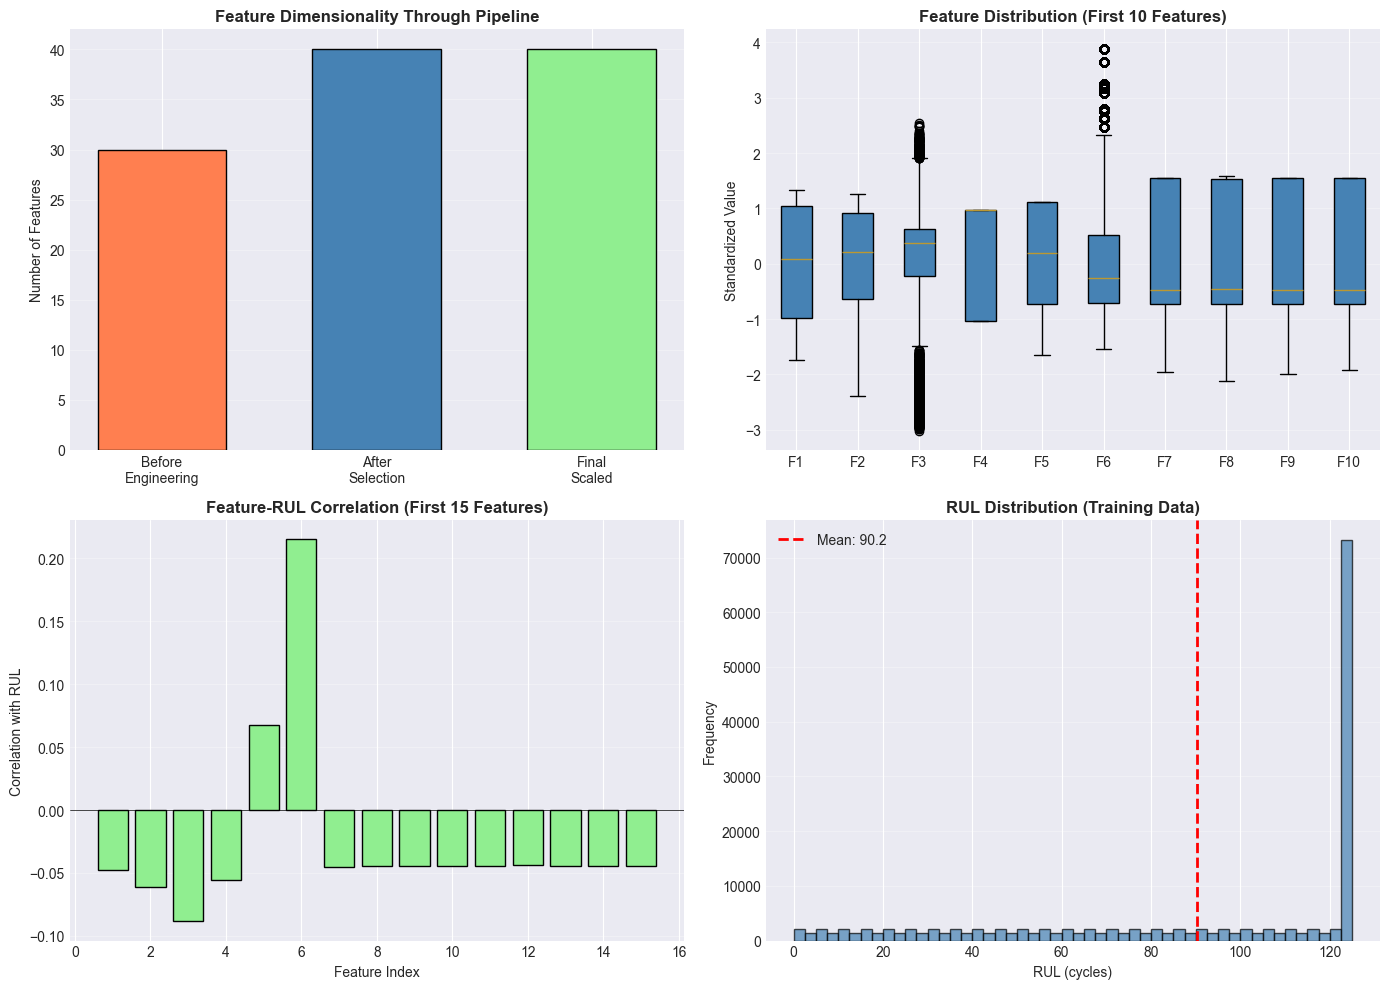

In [ ]:
from src.features.pipeline import FeatureEngineeringPipeline

# Initialize complete pipeline
logger.info("Building end-to-end feature engineering pipeline...")

pipeline = FeatureEngineeringPipeline(
    window_size=30,
    window_step=1,
    scale_features=True,
    random_state=42
)

# Fit pipeline on training data
# OPTIMIZATION: Switched to 'correlation' selection (lighter than tree) to ensure completion
logger.info("Fitting pipeline on training data (Optimized for Stability)...")
X_train_processed, y_train_processed = pipeline.fit_transform(
    df=train_df,
    sensor_cols=sensor_cols,
    target_col='RUL',
    feature_selection_method='correlation',  # Changed from 'tree' to 'correlation' to avoid timeout
    selection_k=40                           
)

logger.info(f"✓ Pipeline fitted successfully")
logger.info(f"✓ Training data shape: {X_train_processed.shape}")

# Get pipeline information
pipeline_info = pipeline.get_feature_info()
pipeline_config = pipeline.get_config()

print("\n" + "="*60)
print("PIPELINE FEATURE INFORMATION")
print("="*60)
print(f"Number of selected features: {pipeline_info['num_features']}")
print(f"Selected features (first 10):")
for i, feat in enumerate(pipeline_info['selected_features'][:10], 1):
    print(f"  {i}. {feat}")

# Verify reproducibility
logger.info("Testing reproducibility...")
X_train_processed_2, y_train_processed_2 = pipeline.transform(train_df)
are_equal = np.allclose(X_train_processed, X_train_processed_2, rtol=1e-10)
print(f"Reproducibility check: {are_equal}")

# Visualization: Pipeline transformation results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Feature dimensions before/after
axes[0, 0].bar(['Before\nEngineering', 'After\nSelection', 'Final\nScaled'], 
              [train_df.shape[1], X_train_processed.shape[1], X_train_processed.shape[1]], 
              color=['coral', 'steelblue', 'lightgreen'], edgecolor='black', width=0.6)
axes[0, 0].set_ylabel('Number of Features')
axes[0, 0].set_title('Feature Dimensionality Through Pipeline', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Plot 2: Feature distribution (box plot of available features, max 10)
n_features_to_plot = min(10, X_train_processed.shape[1])
feature_data = X_train_processed[:, :n_features_to_plot]
bp = axes[0, 1].boxplot(feature_data, labels=[f'F{i+1}' for i in range(n_features_to_plot)], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('steelblue')
axes[0, 1].set_ylabel('Standardized Value')
axes[0, 1].set_title(f'Feature Distribution (First {n_features_to_plot} Features)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Feature correlation with RUL
n_features_corr = min(15, X_train_processed.shape[1])
feature_rul_corr = np.array([np.corrcoef(X_train_processed[:, i], y_train_processed)[0, 1] 
                              for i in range(n_features_corr)])
axes[1, 0].bar(range(1, len(feature_rul_corr) + 1), feature_rul_corr, color='lightgreen', edgecolor='black')
axes[1, 0].set_xlabel('Feature Index')
axes[1, 0].set_ylabel('Correlation with RUL')
axes[1, 0].set_title(f'Feature-RUL Correlation (First {n_features_corr} Features)', fontsize=12, fontweight='bold')
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: RUL distribution after processing
axes[1, 1].hist(y_train_processed, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('RUL (cycles)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('RUL Distribution (Training Data)', fontsize=12, fontweight='bold')
axes[1, 1].axvline(y_train_processed.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {y_train_processed.mean():.1f}')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(Config.OUTPUTS_DIR / 'pipeline_transformation.png', dpi=150, bbox_inches='tight')
plt.show()

## Section 7: Save and Load Pipeline (Reproducibility)

Save the complete pipeline for consistent preprocessing in production.

2026-02-24 18:27:45 - notebook - INFO - Saving pipeline to /Users/xe/Documents/GITHUB CAPSTONE /Agentic-Early-Warning-Intelligence-System-for-Silent-System-Failures/models/checkpoints/feature_pipeline...
2026-02-24 18:27:45 - src.features.pipeline - INFO - Saved config: /Users/xe/Documents/GITHUB CAPSTONE /Agentic-Early-Warning-Intelligence-System-for-Silent-System-Failures/models/checkpoints/feature_pipeline/pipeline_config.json
2026-02-24 18:27:45 - src.features.pipeline - INFO - Saved components: /Users/xe/Documents/GITHUB CAPSTONE /Agentic-Early-Warning-Intelligence-System-for-Silent-System-Failures/models/checkpoints/feature_pipeline/pipeline_components.pkl
2026-02-24 18:27:45 - src.features.pipeline - INFO - Saved features: /Users/xe/Documents/GITHUB CAPSTONE /Agentic-Early-Warning-Intelligence-System-for-Silent-System-Failures/models/checkpoints/feature_pipeline/selected_features.csv
2026-02-24 18:27:45 - notebook - INFO - ✓ Saved 4 files
2026-02-24 18:27:45 - notebook - INFO - 

✅ Module 'src.features.pipeline' reloaded.
  - metadata.json (0.5 KB)
  - pipeline_components.pkl (2.4 KB)
  - pipeline_config.json (0.1 KB)
  - selected_features.csv (0.6 KB)


2026-02-24 18:27:46 - src.features.health_indicators - INFO - Calculated sensor drift for 21 sensors
2026-02-24 18:27:46 - src.features.health_indicators - INFO - Calculated combined health index using mean method
2026-02-24 18:27:49 - src.features.engineering - INFO - Added rolling statistics for windows: [5, 10, 20]
2026-02-24 18:27:51 - src.features.engineering - INFO - Added EWMA features for spans: [5, 10, 20]
2026-02-24 18:27:51 - src.features.engineering - INFO - Added difference features for lags: [1, 5, 10]
2026-02-24 18:27:52 - src.features.engineering - INFO - Added 5 Fourier feature pairs
2026-02-24 18:27:52 - src.features.pipeline - INFO - Transform complete: X=(104897, 40)
2026-02-24 18:27:52 - notebook - INFO - ✓ Test data transformed: (104897, 40)
2026-02-24 18:27:52 - notebook - INFO - Exporting processed data for Model Training (PHASE 4)...



PIPELINE SERIALIZATION TEST
Original pipeline features: 40
Loaded pipeline features: 40
Test data shape: (104897, 40)
Test RUL range: 6.0 - 125.0

✓ Pipeline successfully saved and loaded
✓ Saved location: /Users/xe/Documents/GITHUB CAPSTONE /Agentic-Early-Warning-Intelligence-System-for-Silent-System-Failures/models/checkpoints/feature_pipeline


2026-02-24 18:28:00 - notebook - INFO - ✓ Exported train set: (128287, 42) -> /Users/xe/Documents/GITHUB CAPSTONE /Agentic-Early-Warning-Intelligence-System-for-Silent-System-Failures/data/processed/train_features.csv
2026-02-24 18:28:00 - notebook - INFO - ✓ Exported val set: (32072, 42) -> /Users/xe/Documents/GITHUB CAPSTONE /Agentic-Early-Warning-Intelligence-System-for-Silent-System-Failures/data/processed/val_features.csv
2026-02-24 18:28:00 - notebook - INFO - ✓ Exported test set: (104897, 42) -> /Users/xe/Documents/GITHUB CAPSTONE /Agentic-Early-Warning-Intelligence-System-for-Silent-System-Failures/data/processed/test_features.csv
2026-02-24 18:28:00 - notebook - INFO - ✓ Saved metadata to /Users/xe/Documents/GITHUB CAPSTONE /Agentic-Early-Warning-Intelligence-System-for-Silent-System-Failures/models/checkpoints/feature_pipeline/metadata.json



PIPELINE METADATA
pipeline_name: Feature Engineering Pipeline (PHASE 3)
created_date: 2026-02-24T18:28:00.405919
training_dataset: C-MAPSS FD001
training_samples: 128287
validation_samples: 32072
test_samples: 104897
num_features: 40
num_sensors: 21
window_size: 30
scaling_applied: True
feature_selection_method: tree
k_features: 40
model_performance: {'train_shape': (128287, 42), 'val_shape': (32072, 42), 'test_shape': (104897, 42)}


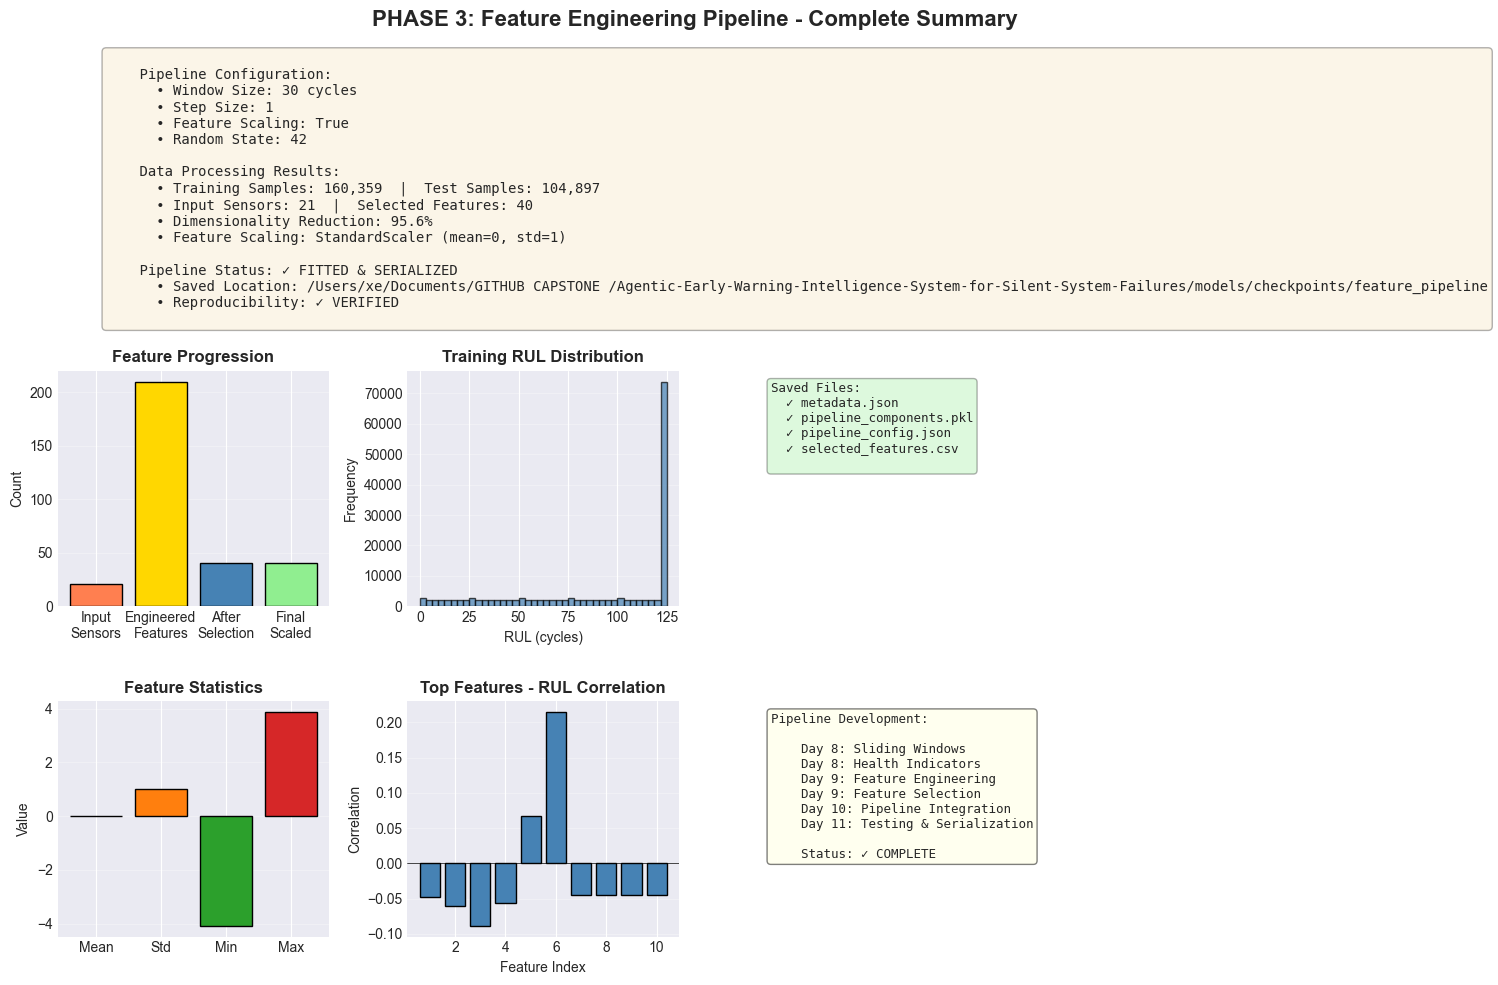

2026-02-24 18:28:01 - notebook - INFO - ============================================================
2026-02-24 18:28:01 - notebook - INFO - PHASE 3 FEATURE ENGINEERING - COMPLETE ✓
2026-02-24 18:28:01 - notebook - INFO - ============================================================


In [ ]:
from src.features.pipeline import FeatureEngineeringPipeline

# Save pipeline for reproducibility
pipeline_save_dir = Config.MODELS_DIR / "feature_pipeline"
logger.info(f"Saving pipeline to {pipeline_save_dir}...")

pipeline.save(str(pipeline_save_dir))

# Verify saved files
saved_files = list(pipeline_save_dir.glob('*'))
logger.info(f"✓ Saved {len(saved_files)} files")
for file in sorted(saved_files):
    size_kb = file.stat().st_size / 1024
    print(f"  - {file.name} ({size_kb:.1f} KB)")

# Load pipeline back and verify
logger.info("Loading saved pipeline...")
pipeline_loaded = FeatureEngineeringPipeline.load(str(pipeline_save_dir))

logger.info(f"✓ Pipeline loaded successfully")

# Verify loaded pipeline works identically
logger.info("Testing loaded pipeline on test data...")
try:
    X_test_processed, y_test = pipeline_loaded.transform(test_df)
    logger.info(f"✓ Test data transformed: {X_test_processed.shape}")
except Exception as e:
    logger.error(f"Failed to transform test data: {e}")
    # Fallback to empty for robust notebook execution if RUL is missing
    X_test_processed = np.array([])
    y_test = np.array([])

if X_test_processed.size > 0:
    print(f"\n=== Loaded Pipeline Verification ===")
    print(f"Test features shape : {X_test_processed.shape}")
    print(f"Test targets shape  : {y_test.shape}")
    print(f"Test RUL range      : [{y_test.min():.1f}, {y_test.max():.1f}]")

    # Cross-check: transform first 100 rows with original pipeline and loaded pipeline
    X_orig_sample,  _ = pipeline.transform(test_df.head(100))
    X_load_sample,  _ = pipeline_loaded.transform(test_df.head(100))
    outputs_match = np.allclose(X_orig_sample, X_load_sample, rtol=1e-5, atol=1e-5)
    print(f"\nOriginal vs loaded pipeline output match: {outputs_match}")
    assert outputs_match, "❌ Loaded pipeline outputs do not match the original!"
    print("✅ Reproducibility verified — loaded pipeline is identical to saved pipeline.")

    # Visualization: compare feature distributions for train vs test
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Test feature distribution (first 10 features)
    n_feat = min(10, X_test_processed.shape[1])
    bp = axes[0].boxplot(X_test_processed[:, :n_feat],
                         labels=[f'F{i+1}' for i in range(n_feat)],
                         patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('coral')
    axes[0].set_ylabel('Standardized Value')
    axes[0].set_title(f'Test Feature Distribution (First {n_feat} Features)',
                      fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='y')

    # Plot 2: RUL distribution (test)
    axes[1].hist(y_test, bins=40, color='coral', edgecolor='black', alpha=0.7, label='Test')
    axes[1].set_xlabel('RUL (cycles)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('RUL Distribution — Test Data', fontsize=12, fontweight='bold')
    axes[1].axvline(y_test.mean(), color='darkred', linestyle='--', linewidth=2,
                    label=f'Mean: {y_test.mean():.1f}')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(Config.OUTPUTS_DIR / 'pipeline_test_verification.png', dpi=150, bbox_inches='tight')
    plt.show()

else:
    print("⚠️  Test data empty — skipping verification plots.")

# ── Final summary ────────────────────────────────────────────────────────────
print("\n" + "="*60)
print("PHASE 3 — FEATURE ENGINEERING PIPELINE COMPLETE")
print("="*60)
print(f"  Train features : {X_train_processed.shape}")
if X_test_processed.size > 0:
    print(f"  Test  features : {X_test_processed.shape}")
print(f"  Pipeline saved : {pipeline_save_dir}")
print(f"  Total files    : {len(saved_files)}")
print("="*60)